# Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Reading Data

In [4]:
dataset_info_df=pd.read_csv("dataset_info.csv")
merged_df= pd.read_csv("merged_file.csv")

# Data Preparation

In [6]:
merged_df = merged_df[merged_df['Framework'] != 'X-Stream']
merged_df = merged_df[merged_df['Workload'] != 'preprocess']
merged_df = merged_df[merged_df['Workload'] != 'Preprocess']
merged_df = merged_df[merged_df['Workload'] != 'binaryconversion']
merged_df = merged_df[merged_df['Workload'] != 'OneStepNeighbor']
merged_df = merged_df[merged_df['Workload'] != 'TwoStepNeighbor']
merged_df = merged_df.dropna()
# Streamline the Workload column. OneStepNeighbor


In [8]:
unique_workloads = merged_df['Workload'].unique()
print(unique_workloads)
def streamline_workload(workload):
    if pd.isna(workload):
        return workload
    if 'ConnectedComponent' in workload or 'Components' in workload or workload == 'CC' or workload == 'WCC':
        return 'CC'
    if 'TriangleCounting' in workload or 'Triangle' in workload or 'TC' in workload:
        return 'TC'
    if 'BFS' in workload :
        return 'BFS'
    if 'BC' in workload :
        return 'BC'
    if 'PageRank' in workload or 'PR' in workload:
        if '10' in workload:
            return 'PR10'
        elif '20' in workload:
            return 'PR20'
    return workload

merged_df['Workload'] = merged_df['Workload'].apply(streamline_workload)
print(merged_df['Workload'].unique())

['CC' 'PR10' 'PR20' 'TC' 'MinimumSpanningForest' 'CommunityDetection'
 'BFS' 'appr' 'BC' 'MIS' 'Radii']
['CC' 'PR10' 'PR20' 'TC' 'MinimumSpanningForest' 'CommunityDetection'
 'BFS' 'appr' 'BC' 'MIS' 'Radii']


In [9]:
dataset_info_dict = dataset_info_df.set_index('Dataset').to_dict('index')

# Add 'Edges' and 'Nodes' columns to merged_df
merged_df['Edges'] = merged_df['Dataset'].map(lambda x: dataset_info_dict[x]['Edges'])
merged_df['Nodes'] = merged_df['Dataset'].map(lambda x: dataset_info_dict[x]['Nodes'])
merged_df['Size'] = merged_df['Dataset'].map(lambda x: dataset_info_dict[x]['Size'])
merged_df.shape

(2916, 17)

In [10]:
# Ensure execution times are numeric
merged_df['Execution Time (s)'] = pd.to_numeric(merged_df['Execution Time (s)'])
merged_df = merged_df.dropna(subset=['Execution Time (s)'])
merged_df = merged_df[~((merged_df['Edges'] > 200000000) & (merged_df['Execution Time (s)'] < 1))]

# Encode categorical features
label_encoder_workload = LabelEncoder()
print(merged_df['Workload'].unique())
merged_df['Workload'] = label_encoder_workload.fit_transform(merged_df['Workload'])
print(merged_df['Workload'].unique())
dataset = merged_df['Dataset']

# Define features and target for the KNN model
features = ['Workload', 'Edges', 'Nodes', 'Size']
X = merged_df[features]
y = merged_df['Framework']
execution_time = merged_df['Execution Time (s)']

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

['CC' 'PR10' 'PR20' 'TC' 'MinimumSpanningForest' 'CommunityDetection'
 'BFS' 'appr' 'BC' 'MIS' 'Radii']
[ 2  6  7  9  5  3  1 10  0  4  8]


# Benchmarking ML models

In [13]:
# Benchmarking ML Models
def benchmark_models_with_cv(X, y, k=5):
    models = {
        "KNN": KNeighborsClassifier(),
        "SVM": SVC(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(),
        "Decision Tree": DecisionTreeClassifier()
    }
    results_list = []  # Collect results for DataFrame
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for name, model in models.items():
        fold_accuracies = []
        fold_precisions = []
        fold_recalls = []
        fold_f1s = []
        print(f"\n{name} Model")
        for fold, (train_index, test_index) in enumerate(kf.split(X)):
            X_train_cv, X_test_cv = X[train_index], X[test_index]
            y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

            model.fit(X_train_cv, y_train_cv)
            y_pred_cv = model.predict(X_test_cv)
            accuracy = accuracy_score(y_test_cv, y_pred_cv)
            precision = precision_score(y_test_cv, y_pred_cv, average='macro')
            recall = recall_score(y_test_cv, y_pred_cv, average='macro')
            f1 = f1_score(y_test_cv, y_pred_cv, average='macro')

            fold_accuracies.append(accuracy)
            fold_precisions.append(precision)
            fold_recalls.append(recall)
            fold_f1s.append(f1)

            print(f"Fold {fold + 1}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}")

        mean_accuracy = np.mean(fold_accuracies)
        mean_precision = np.mean(fold_precisions)
        mean_recall = np.mean(fold_recalls)
        mean_f1 = np.mean(fold_f1s)

        results_list.append({
            "Model": name,
            "Mean Accuracy": mean_accuracy,
            "Mean Precision": mean_precision,
            "Mean Recall": mean_recall,
            "Mean F1-Score": mean_f1
        })

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results_list)

    return results_df

# Perform benchmarking with K-Fold Cross Validation
results_df = benchmark_models_with_cv(X, y)

# Display the results DataFrame
print("\nModel Benchmarking Results with K-Fold Cross Validation:")
results_df.head(10)





KNN Model
Fold 1: Accuracy = 0.4766, Precision = 0.5451, Recall = 0.4706, F1-Score = 0.4599
Fold 2: Accuracy = 0.4419, Precision = 0.5448, Recall = 0.4387, F1-Score = 0.4280
Fold 3: Accuracy = 0.4298, Precision = 0.5211, Recall = 0.4433, F1-Score = 0.4161
Fold 4: Accuracy = 0.4913, Precision = 0.5438, Recall = 0.4764, F1-Score = 0.4657
Fold 5: Accuracy = 0.4392, Precision = 0.5144, Recall = 0.4524, F1-Score = 0.4211

SVM Model
Fold 1: Accuracy = 0.3224, Precision = 0.3302, Recall = 0.3152, F1-Score = 0.3043
Fold 2: Accuracy = 0.3189, Precision = 0.3369, Recall = 0.3080, F1-Score = 0.3058
Fold 3: Accuracy = 0.3501, Precision = 0.3974, Recall = 0.3568, F1-Score = 0.3438
Fold 4: Accuracy = 0.3490, Precision = 0.3727, Recall = 0.3563, F1-Score = 0.3507
Fold 5: Accuracy = 0.3333, Precision = 0.4055, Recall = 0.3448, F1-Score = 0.3166

Logistic Regression Model
Fold 1: Accuracy = 0.2912, Precision = 0.2923, Recall = 0.2825, F1-Score = 0.2562
Fold 2: Accuracy = 0.3172, Precision = 0.2582, Re

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1: Accuracy = 0.4627, Precision = 0.4675, Recall = 0.4663, F1-Score = 0.4570
Fold 2: Accuracy = 0.4749, Precision = 0.5123, Recall = 0.4782, F1-Score = 0.4645
Fold 3: Accuracy = 0.4419, Precision = 0.4931, Recall = 0.4522, F1-Score = 0.4420
Fold 4: Accuracy = 0.5000, Precision = 0.5123, Recall = 0.4949, F1-Score = 0.4883
Fold 5: Accuracy = 0.4618, Precision = 0.5135, Recall = 0.4754, F1-Score = 0.4642

Decision Tree Model
Fold 1: Accuracy = 0.4627, Precision = 0.4716, Recall = 0.4665, F1-Score = 0.4608
Fold 2: Accuracy = 0.4645, Precision = 0.4936, Recall = 0.4689, F1-Score = 0.4562
Fold 3: Accuracy = 0.4402, Precision = 0.4826, Recall = 0.4504, F1-Score = 0.4383
Fold 4: Accuracy = 0.4878, Precision = 0.4999, Recall = 0.4849, F1-Score = 0.4775
Fold 5: Accuracy = 0.4635, Precision = 0.5083, Recall = 0.4741, F1-Score = 0.4663

Model Benchmarking Results with K-Fold Cross Validation:


,Model,Mean Accuracy,Mean Precision,Mean Recall,Mean F1-Score
0,KNN,0.455782,0.533841,0.456287,0.438146
1,SVM,0.334725,0.368506,0.336226,0.324242
2,Logistic Regression,0.303843,0.284067,0.298123,0.260911
3,Random Forest,0.468271,0.499723,0.473435,0.463212
4,Decision Tree,0.463761,0.491212,0.468969,0.459817


# Knn models results


In [17]:
X_train, X_test, y_train, y_test, execution_time_train, execution_time_test, dataset_train, dataset_test = train_test_split(
    X, y, execution_time, dataset, test_size=0.2, random_state=42, stratify=y)

# Grid Search for ordinary KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}
grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
grid_knn.fit(X_train, y_train)

# Collect results into a list for the DataFrame
results_list = []

for params, mean_score, std_score in zip(
    grid_knn.cv_results_['params'],
    grid_knn.cv_results_['mean_test_score'],
    grid_knn.cv_results_['std_test_score']
):
    # Fit the model with the current parameters
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append results to the list
    results_list.append({
        "Params": params,
        "Mean Accuracy": mean_score,
        "Std Dev": std_score,
        "Precision (Macro)": precision,
        "Recall (Macro)": recall,
        "F1-Score (Macro)": f1
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results_list)

# Display the DataFrame
print("\nGrid Search Results for Ordinary KNN:")
results_df.head(12)



Grid Search Results for Ordinary KNN:


,Params,Mean Accuracy,Std Dev,Precision (Macro),Recall (Macro),F1-Score (Macro)
0,"{'metric': 'euclidean', 'n_neighbors': 3}",0.411113,0.020262,0.428469,0.436172,0.416918
1,"{'metric': 'euclidean', 'n_neighbors': 5}",0.422811,0.019329,0.463402,0.455242,0.447695
2,"{'metric': 'euclidean', 'n_neighbors': 7}",0.411975,0.019082,0.463032,0.446563,0.439607
3,"{'metric': 'euclidean', 'n_neighbors': 9}",0.418478,0.022531,0.439734,0.438135,0.433645
4,"{'metric': 'manhattan', 'n_neighbors': 3}",0.410245,0.018850,0.428469,0.436172,0.416918
5,"{'metric': 'manhattan', 'n_neighbors': 5}",0.421944,0.017672,0.463402,0.455242,0.447695
6,"{'metric': 'manhattan', 'n_neighbors': 7}",0.414144,0.021815,0.457837,0.440623,0.433932
7,"{'metric': 'manhattan', 'n_neighbors': 9}",0.419779,0.024829,0.435213,0.432194,0.428599
8,"{'metric': 'chebyshev', 'n_neighbors': 3}",0.411113,0.020262,0.428469,0.436172,0.416918
9,"{'metric': 'chebyshev', 'n_neighbors': 5}",0.422377,0.018600,0.463402,0.455242,0.447695


# Custom K-NN results

In [23]:
system_capabilities = {
    'Ligra': 1,  # in-memory
    'GPOP': 1,   # in-memory
    'Mmap': 1.5, # optimized in-memory
    'GraphChi': 3, # out-of-core
    'GridGraph': 2 # hybrid
}

In [24]:
def predict_best_system(X_test, execution_time_train, y_train, knn_model, alpha, beta):
    distances, indices = knn_model.kneighbors(X_test)
    predicted_systems = []
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        closest_execution_times = execution_time_train.iloc[idx].values
        closest_systems = y_train.iloc[idx].values

        # Count the number of neighbors for each system
        system_counts = pd.Series(closest_systems).value_counts()

        # Calculate weighted scores
        system_scores = {}
        for system in system_counts.index:
            system_execution_times = closest_execution_times[closest_systems == system]
            avg_execution_time_log = np.mean(np.log(system_execution_times + 1))  # Logarithmic scale
            count_of_neighbors = system_counts[system]
            capability_adjustment = system_capabilities[system]
            system_scores[system] = (alpha * avg_execution_time_log) + (beta * (1 / count_of_neighbors))

        best_system = min(system_scores, key=system_scores.get)
        predicted_systems.append(best_system)
    return np.array(predicted_systems)

In [25]:
custom_results = []

for k in [3, 5, 7]:
    for metric in ['euclidean', 'manhattan', 'chebyshev']:
        for alpha in [0.2, 0.35, 0.5, 0.65, 0.8]:
            # Initialize the NearestNeighbors model with current grid search parameters
            knn_model = NearestNeighbors(n_neighbors=k, metric=metric)
            knn_model.fit(X_train)

            # Predict using the updated predict_best_system function
            y_pred = predict_best_system(X_test, execution_time_train, y_train, knn_model, alpha=alpha, beta=1 - alpha)

            # Calculate metrics
            accuracy = round(accuracy_score(y_test, y_pred), 2)
            precision = round(precision_score(y_test, y_pred, average='macro'), 2)
            recall = round(recall_score(y_test, y_pred, average='macro'), 2)
            f1 = round(f1_score(y_test, y_pred, average='macro'), 2)

            # Append results to the list
            custom_results.append({
                'k': k,
                'metric': metric,
                'alpha': alpha,
                'beta': round(1 - alpha, 2),
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1
            })

# Convert results to a DataFrame
custom_results_df = pd.DataFrame(custom_results)

# Display the DataFrame
print("\nGrid Search Results for Custom KNN:")
print(custom_results_df)


Grid Search Results for Custom KNN:
    k     metric  alpha  beta  accuracy  precision  recall    f1
0   3  euclidean   0.20  0.80      0.42       0.45    0.42  0.42
1   3  euclidean   0.35  0.65      0.41       0.44    0.41  0.40
2   3  euclidean   0.50  0.50      0.41       0.45    0.41  0.40
3   3  euclidean   0.65  0.35      0.40       0.45    0.40  0.40
4   3  euclidean   0.80  0.20      0.40       0.48    0.40  0.39
5   3  manhattan   0.20  0.80      0.42       0.44    0.42  0.41
6   3  manhattan   0.35  0.65      0.40       0.43    0.40  0.39
7   3  manhattan   0.50  0.50      0.40       0.44    0.40  0.39
8   3  manhattan   0.65  0.35      0.40       0.45    0.40  0.39
9   3  manhattan   0.80  0.20      0.39       0.47    0.39  0.38
10  3  chebyshev   0.20  0.80      0.42       0.45    0.42  0.42
11  3  chebyshev   0.35  0.65      0.41       0.44    0.41  0.40
12  3  chebyshev   0.50  0.50      0.41       0.45    0.41  0.40
13  3  chebyshev   0.65  0.35      0.40       0.45   

# Chosen Model

Accuracy: 0.42
              precision    recall  f1-score   support

        GPOP       0.46      0.60      0.52       113
    GraphChi       0.91      0.21      0.34       101
   GridGraph       0.40      0.50      0.44       119
       Ligra       0.47      0.31      0.37       127
        Mmap       0.32      0.47      0.38       117

    accuracy                           0.42       577
   macro avg       0.51      0.42      0.41       577
weighted avg       0.50      0.42      0.41       577

           GPOP  GraphChi  GridGraph  Ligra  Mmap
GPOP         68         0         22      3    20
GraphChi     17        21          8      9    46
GridGraph    19         2         59     10    29
Ligra        18         0         46     39    24
Mmap         26         0         14     22    55


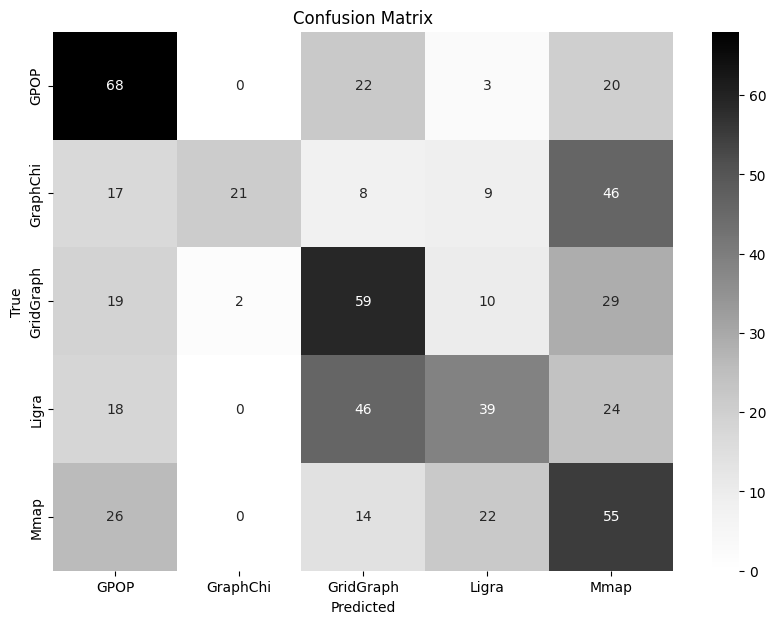

In [29]:
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(X_train)
y_pred = predict_best_system(X_test, execution_time_train, y_train, knn, 0.35, 0.65)

accuracy = round(accuracy_score(y_test, y_pred), 2)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Print the confusion matrix as a table


# Additional evaluation with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
print(cm_df)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('cm.pdf', dpi=300)
plt.show()